# Test Systems

Uses REBOUND commit 25f856dc2f79e0ad17b2f6bd604225f550593376

Test trained models on real non-resonant systems

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import random
import rebound
import dask.dataframe as dd
import pickle
import warnings
warnings.filterwarnings('ignore')
plt.style.use('paper.mplstyle')
%matplotlib inline

In [2]:
if rebound.__githash__ != '25f856dc2f79e0ad17b2f6bd604225f550593376':
    print('Should checkout commit above to ensure this runs correctly')

Should checkout commit above to ensure this runs correctly


In [3]:
path = '../data/nonressystems/Kepler-431/simulation_archives/runs/'

In [4]:
from celmech import Andoyer

def get_k(row):
    sa = rebound.SimulationArchive(path+'sa'+row['runstring'])
    sim = sa[0]
    p2 = sim.particles[2]
    row['h'] = p2.e*np.sin(p2.pomega)
    row['k'] = p2.e*np.cos(p2.pomega)
    avars = Andoyer.from_Simulation(sim, a10=sim.particles[1].a, j=5, k=1, i1=1, i2=2, average=False)
    row['Z12'] = avars.Z
    row['Zcom12'] = avars.Zcom
    avars = Andoyer.from_Simulation(sim, a10=sim.particles[1].a, j=4, k=1, i1=2, i2=3, average=False)
    row['Z23'] = avars.Z
    row['Zcom23'] = avars.Zcom
    return row

In [5]:
trainpath = '../training_data/nonressystems/Kepler-431/spock_featuresNorbits10000.0Nout80trio/'
labels = pd.read_csv(trainpath + 'labels.csv', index_col=0)
# Create k and h columns for plotting
labels['k'] = 0.
labels['h'] = 0.
labels['Z12'] = 0.
labels['Zcom12'] = 0.
labels['Z23'] = 0.
labels['Zcom23'] = 0.

In [6]:
%%time
dasklabels = dd.from_pandas(labels, npartitions=24)
dasklabels = dasklabels.apply(get_k, axis=1, meta=labels).compute(scheduler='processes')

CPU times: user 356 ms, sys: 244 ms, total: 600 ms
Wall time: 1.31 s


In [7]:
dasklabels.head()

,runstring,instability_time,shadow_instability_time,Stable,k,h,Z12,Zcom12,Z23,Zcom23
0,0000000.bin,7.485924e+01,1.060708e+02,False,0.005465,0.000371,0.119594,0.136491,0.003560,0.001432
1,0000001.bin,9.990000e+08,9.990000e+08,True,-0.003233,0.001987,0.002996,0.004223,0.014028,0.013678
2,0000002.bin,9.990000e+08,9.990000e+08,True,0.002167,-0.006424,0.024153,0.006959,0.004783,0.001058
3,0000003.bin,1.648912e+01,1.648912e+01,False,-0.003925,-0.016795,0.038200,0.039534,0.161763,0.209095
4,0000004.bin,9.990000e+08,9.990000e+08,True,-0.000006,0.000600,0.000473,0.000084,0.017975,0.025508


In [9]:
from spock import spockClassifier

model = spockClassifier()
# Make predictions on the simulations using passed model
tdata = pd.read_csv(trainpath + 'trainingdata.csv', index_col=0)
tdata = tdata[model.features]

In [10]:
%%time
threshold=0.5
proba = model.predict_trio(tdata)
stablemask = dasklabels['Stable'] == True
unstablemask = dasklabels['Stable'] == False
pstablemask = proba > threshold
punstablemask = proba < threshold

CPU times: user 9.32 s, sys: 466 ms, total: 9.79 s
Wall time: 290 ms


In [11]:
stablemask.sum()

1095

In [12]:
unstablemask.sum()

405

# TPR

In [14]:
(stablemask & pstablemask).sum()/stablemask.sum()

0.9744292237442922

# FPR

In [18]:
1-(unstablemask & punstablemask).sum()/unstablemask.sum()

0.12592592592592589

In [269]:
(unstablemask & punstablemask).sum()/unstablemask.sum()

0.9209876543209876

# Fraction that agree

In [16]:
((stablemask & pstablemask).sum() + (unstablemask & punstablemask).sum())/(stablemask.sum() + unstablemask.sum())

0.9473333333333334

In [270]:
((stablemask & pstablemask).sum() + (unstablemask & punstablemask).sum())/(stablemask.sum() + unstablemask.sum())

0.9533333333333334

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

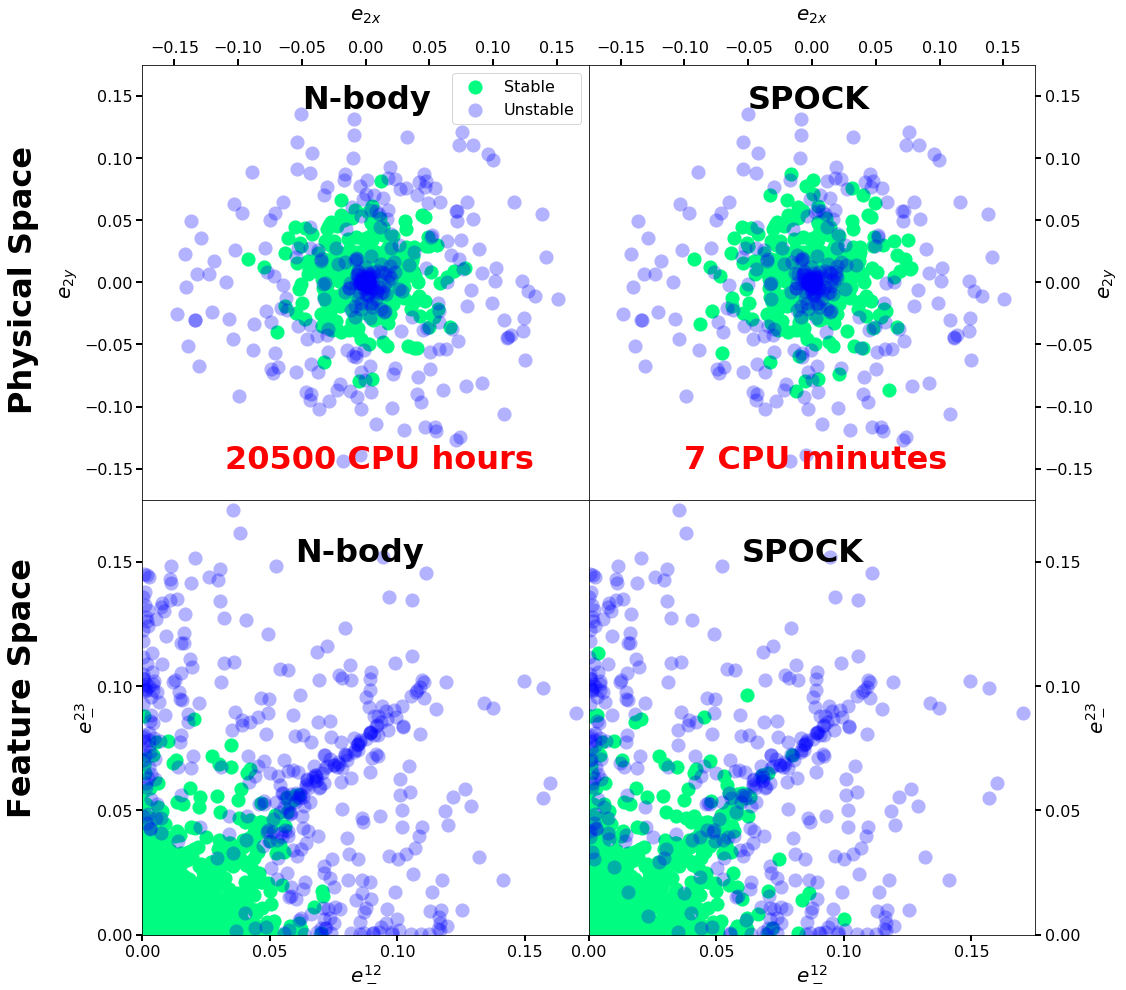

In [17]:
fig, axarr = plt.subplots(nrows=2, ncols=2, figsize=[16, 16])
plt.subplots_adjust(hspace=0, wspace=0)


colorbar = 'winter'
cmap = matplotlib.cm.get_cmap(colorbar)
s=200
axarr[0,0].scatter(dasklabels["k"][stablemask], dasklabels["h"][stablemask], c=cmap(0.99), s=s, lw=0, label='Stable')
axarr[0,0].scatter(dasklabels["k"][unstablemask], dasklabels["h"][unstablemask], c=cmap(0.), s=s, lw=0, label='Unstable', alpha=0.3)
axarr[0,1].scatter(dasklabels["k"][pstablemask], dasklabels["h"][pstablemask], c=cmap(0.99), s=s, lw=0, label='Stable')
axarr[0,1].scatter(dasklabels["k"][punstablemask], dasklabels["h"][punstablemask], c=cmap(0.), s=s, lw=0, label='Unstable', alpha=0.3)
axarr[0,1].tick_params(axis='y', which='both', left='off', right='off')
axarr[0,0].text(-0.11, -0.15, '20500 CPU hours', weight='bold', size=32, color='red')
axarr[0,1].text(-0.1, -0.15, '7 CPU minutes', weight='bold', size=32, color='red')
axarr[0,0].text(-0.05, 0.14, 'N-body', weight='bold', size=32)
axarr[0,1].text(-0.05, 0.14, 'SPOCK', weight='bold', size=32)
axarr[0,0].text(-0.28, -0.1, 'Physical Space', weight='bold', size=32, rotation=90)

lim = 0.175
axarr[0,0].set_xlim([-lim, lim])
axarr[0,0].set_ylim([-lim, lim])
axarr[0,1].set_xlim([-lim, lim])
axarr[0,1].set_ylim([-lim, lim])
axarr[0,0].legend()
axarr[0,1].yaxis.tick_right()
axarr[0,0].xaxis.tick_top()
axarr[0,1].xaxis.tick_top()


axarr[0,0].set_xlabel(r'$e_{2x}$', labelpad=20)
axarr[0,0].set_ylabel(r'$e_{2y}$')
axarr[0,1].set_xlabel(r'$e_{2x}$', labelpad=20)
axarr[0,1].set_ylabel(r'$e_{2y}$')
axarr[0,1].yaxis.set_label_position("right")
axarr[0,0].xaxis.set_label_position("top")
axarr[0,1].xaxis.set_label_position("top")


s=200
axarr[1,0].scatter(dasklabels["Z12"][stablemask], dasklabels["Z23"][stablemask], c=cmap(0.99), s=s, lw=0, label='Stable')
axarr[1,0].scatter(dasklabels["Z12"][unstablemask], dasklabels["Z23"][unstablemask], c=cmap(0.), s=s, lw=0, label='Unstable', alpha=0.3)
axarr[1,1].scatter(dasklabels["Z12"][pstablemask], dasklabels["Z23"][pstablemask], c=cmap(0.99), s=s, lw=0, label='Stable')
axarr[1,1].scatter(dasklabels["Z12"][punstablemask], dasklabels["Z23"][punstablemask], c=cmap(0.), s=s, lw=0, label='Unstable', alpha=0.3)
axarr[1,1].tick_params(axis='y', which='both', left='off', right='off')
axarr[1,0].text(0.06, 0.15, 'N-body', weight='bold', size=32)
axarr[1,1].text(0.06, 0.15, 'SPOCK', weight='bold', size=32)
axarr[1,0].text(-0.053, 0.05, 'Feature Space', weight='bold', size=32, rotation=90)


axarr[1,0].set_xlim([0, lim])
axarr[1,0].set_ylim([0, lim])
axarr[1,1].set_xlim([0, lim])
axarr[1,1].set_ylim([0, lim])
axarr[1,0].set_xticks([0, 0.05, 0.1, 0.15])
axarr[1,0].set_yticks([0, 0.05, 0.1, 0.15])
axarr[1,1].set_xticks([0, 0.05, 0.1, 0.15])
axarr[1,1].set_yticks([0, 0.05, 0.1, 0.15])
axarr[1,1].yaxis.tick_right()
axarr[1,1].yaxis.set_label_position("right")


axarr[1,0].set_xlabel(r'$e_-^{12}$')
axarr[1,0].set_ylabel(r'$e_-^{23}$')
axarr[1,1].set_xlabel(r'$e_-^{12}$')
axarr[1,1].set_ylabel(r'$e_-^{23}$')



fig.savefig('kep431.pdf', bbox_inches='tight')